# 1 Importing Libraries & Setting Parameters

## Importing Libraries

In [ ]:
import pandas as pd

# preprocessing
import numpy as np
from sklearn.preprocessing import StandardScaler

# viz
import seaborn as sns
import matplotlib.pyplot as plt

# stats
from scipy.stats import shapiro
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

# modelling
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score


## Initializing Parameters

In [ ]:
vif_threshold = 5      # 5
pval_threshold = 0.05
alpha = 0.1     # for sklearn models
l1_ratio = 0.5

In [ ]:
!gdown 1kQu3NuYBkXUQee4VHKndes7v1JYPDP8i
# https://drive.google.com/file/d/1kQu3NuYBkXUQee4VHKndes7v1JYPDP8i/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1kQu3NuYBkXUQee4VHKndes7v1JYPDP8i
To: /content/Jamboree_Admission.csv
100% 16.2k/16.2k [00:00<00:00, 30.7MB/s]


# DataFrame Overview

In [ ]:
df = pd.read_csv('Jamboree_Admission.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


## Standardizing Columns Names

In [ ]:
df.columns = [  str.lower(str.strip(c).replace('.', '')).replace(' ', '_') for c in df.columns]
df.columns

Index(['serial_no', 'gre_score', 'toefl_score', 'university_rating', 'sop',
       'lor', 'cgpa', 'research', 'chance_of_admit'],
      dtype='object')

## Columns Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   serial_no          500 non-null    int64  
 1   gre_score          500 non-null    int64  
 2   toefl_score        500 non-null    int64  
 3   university_rating  500 non-null    int64  
 4   sop                500 non-null    float64
 5   lor                500 non-null    float64
 6   cgpa               500 non-null    float64
 7   research           500 non-null    int64  
 8   chance_of_admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


* There are total of 500 rows

In [ ]:
df = df.rename(columns={'chance_of_admit': 'chance_admit'})

In [ ]:
df.describe()

,serial_no,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


* SOP, LOR, University Rating are in range 1 to 5, they seem to be ratings
* Serial Number is insignificant, checking if all rows are unique serial number can be dropped
* cgpa is 10 scale grading, with max value of 9.92, and 8.56 is median cgpa.
* gre_scores are also on higher side as median gre_score is 317, with 340 as max marks
* toefl_score are also higher, with 107 being median marks.  
* GRE, TOEFL marks and CGPA values suggest that good merit students are mostly applying.
* chance_of_admit is in percentage


In [ ]:
df['serial_no'].duplicated().sum()

0

* Each serial number is unique, there are no duplicates, Serial Number is removed from X features, as it holds no useful information regarding chance of admission.


In [ ]:
for col in ['sop', 'lor', 'research', 'university_rating']:
  print(f'{col} ---->', sorted(df[col].unique()))


sop ----> [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
lor ----> [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
research ----> [0, 1]
university_rating ----> [1, 2, 3, 4, 5]


* sop, lor, university rating have ordinal values (order matters), although these are not continuous, but can be taken as continuous for Linear Regression
* research is a categorical feature, since there are only 2 distinct values 0, 1, it can be taken as is for Linear Regression

In [ ]:
df = df.drop(columns=['serial_no'], axis=1)

# Missing values

In [ ]:
df.isna().sum()

,0
gre_score,0
toefl_score,0
university_rating,0
sop,0
lor,0
cgpa,0
research,0
chance_admit,0


* There are no missing values present in dataframe

# Data Analysis

In [ ]:
def plot_dist(df, col):

  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  sns.histplot(df[col], kde=True)    # , bins=100

  plt.subplot(1, 2, 2)
  sns.boxplot(df[col])    # , bins=100

  plt.show()


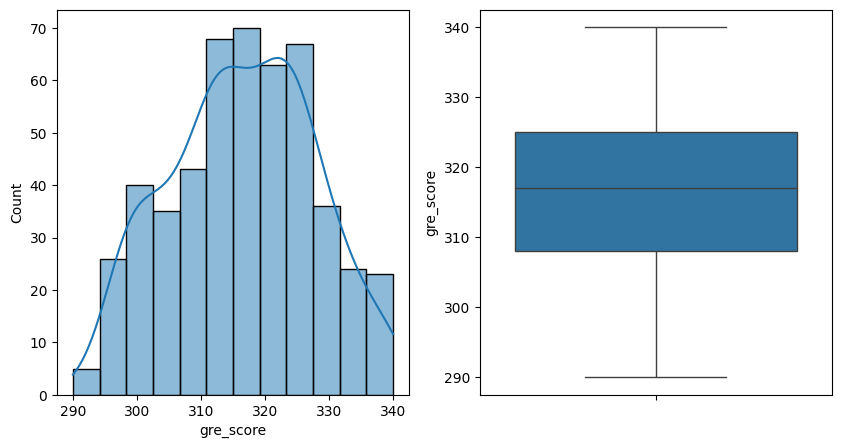

Skewness : -0.03984185809159066
Kurtosis : -0.7110644625938418
Mean : 316.472
Median : 317.0


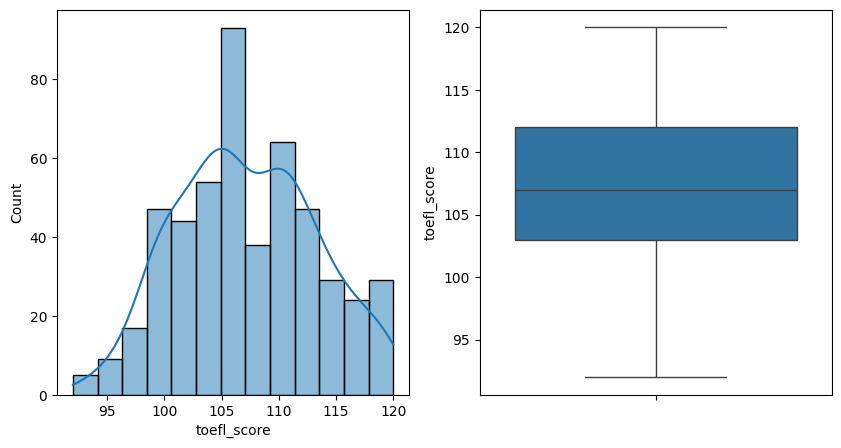

Skewness : 0.09560097235726285
Kurtosis : -0.6532454042173863
Mean : 107.192
Median : 107.0


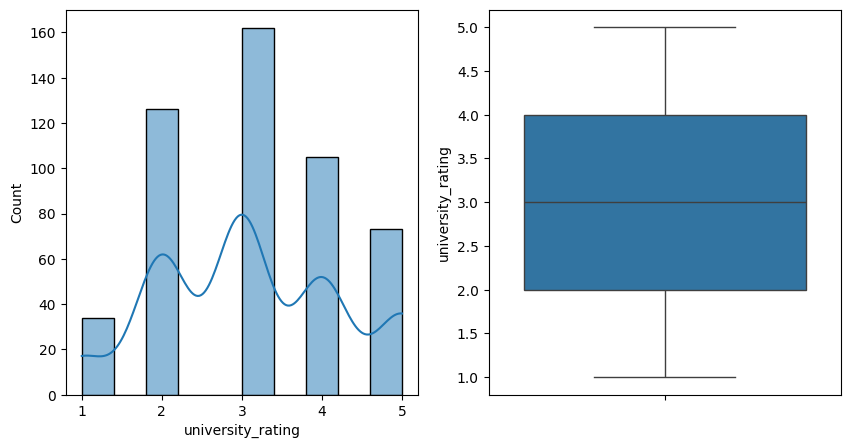

Skewness : 0.09029498312712977
Kurtosis : -0.8100796635331018
Mean : 3.114
Median : 3.0


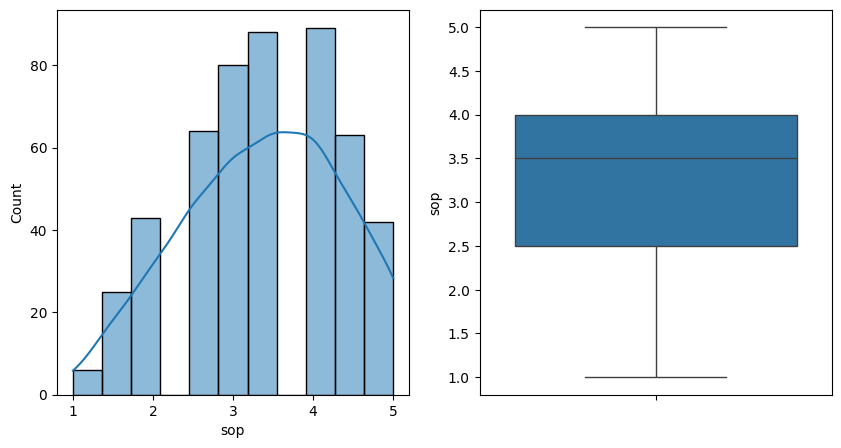

Skewness : -0.22897239628779945
Kurtosis : -0.7057169536396795
Mean : 3.374
Median : 3.5


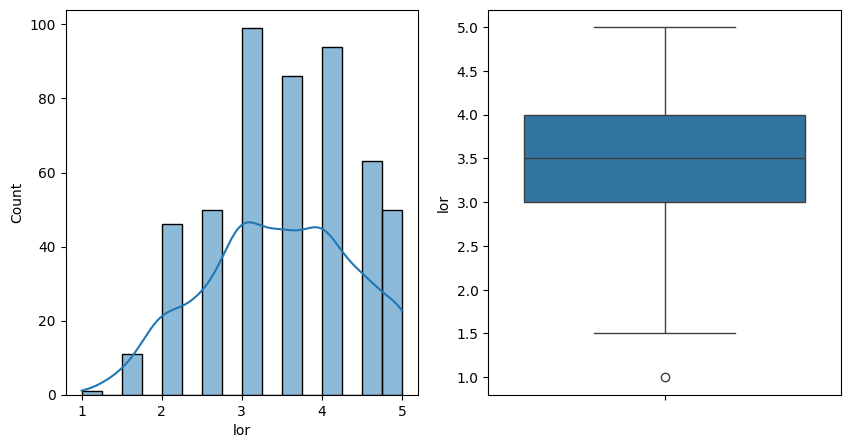

Skewness : -0.1452903146082398
Kurtosis : -0.7457485105986423
Mean : 3.484
Median : 3.5


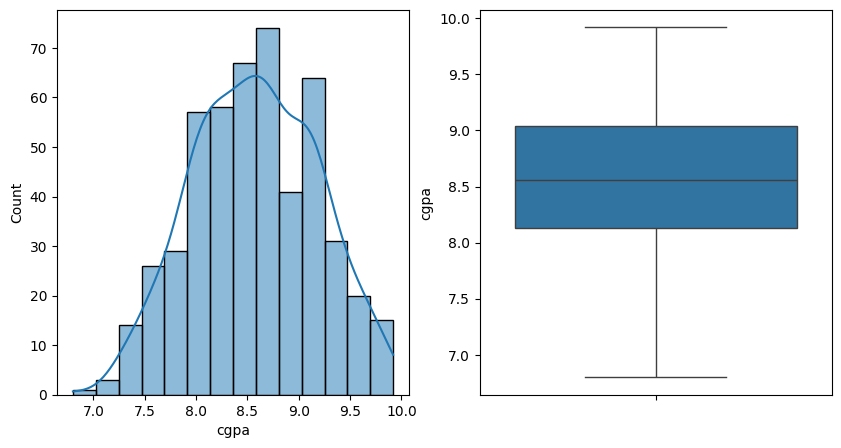

Skewness : -0.026612517318359303
Kurtosis : -0.5612783980560527
Mean : 8.576439999999998
Median : 8.56


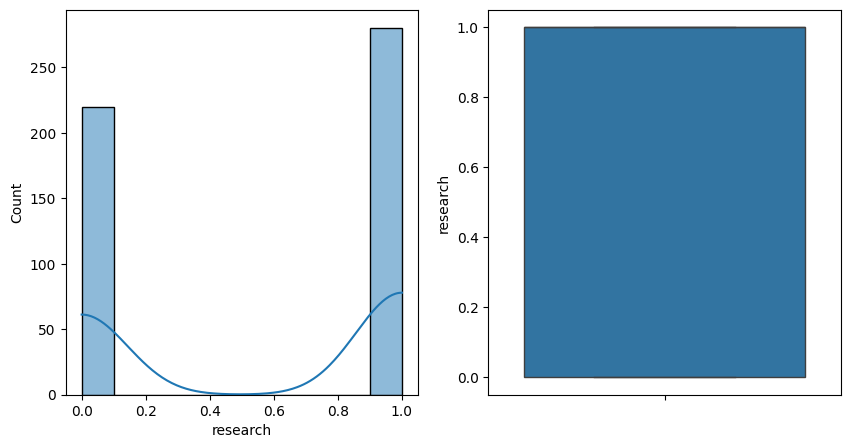

Skewness : -0.24247492100796933
Kurtosis : -1.9490180796876393
Mean : 0.56
Median : 1.0


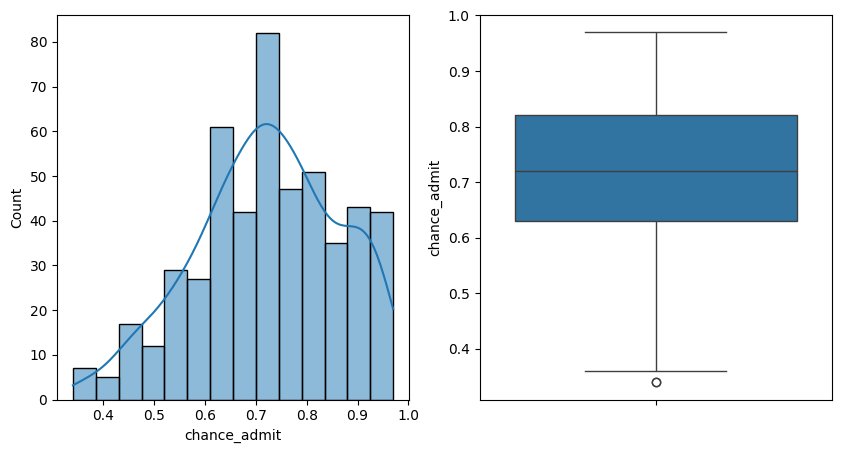

Skewness : -0.289966210041158
Kurtosis : -0.4546817998465431
Mean : 0.72174
Median : 0.72


In [ ]:
for col in df.columns:
  plot_dist(df, col)
  print(f"Skewness : {df[col].skew()}")
  print(f"Kurtosis : {df[col].kurt()}")
  print(f"Mean : {df[col].mean()}")
  print(f"Median : {df[col].median()}")

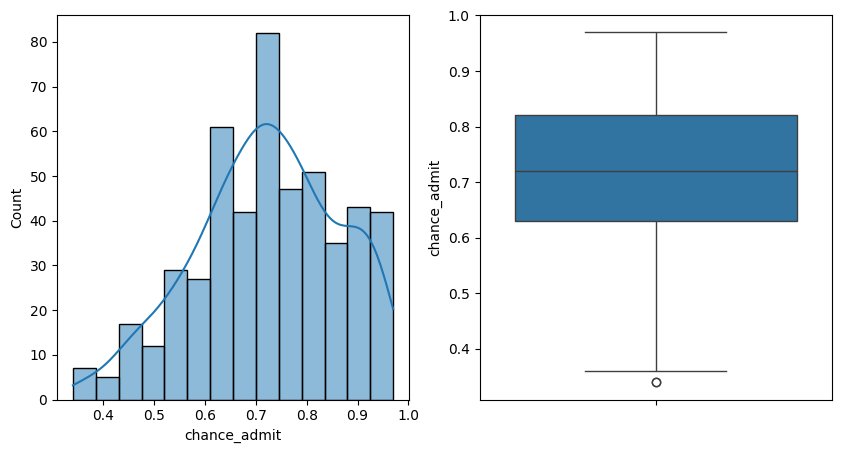

In [ ]:
plot_dist(df, 'chance_admit')

* gre_score has shallow peak signifying few chances of outliers, and is very slight left skewness. Boxplot confirms absence of outliers.


* university_rating are mostly 3, followed by 2 and 4. Ratings are distinctly from 1 to 5.

* Sop is slightly left skewed, low kurtosis signifies shallow peak and few chance of outliers, and no outliers are confirmed with boxplot. Below are overall statistics.

* lor is left skewed, low kurtosis signifies shallow peak and few chances of outliers. Boxplot shows few outliers around value 1, but the outlier can be kept as it is defined range of lor. Below are overall statistics.

* cgpa is slightly left skewed, low kurtosis signifies shallow peak and few chances of outliers, and no outliers are confirmed with boxplot. Below are overall statistics.

* chance_of_admit is left skewed, low kurtosis signifies shallow peak and few chances of outliers. There are few outliers observed in boxplot, but outliers are closer to the whisker and also lie in acceptable range, this outlier will not be removed. Below are overall statistics.


In [ ]:
print(f"Percentage of students with research experience are : {df[df['research'] == 1].shape[0] / df.shape[0] * 100}%")
print(f"Percentage of students without research experience are : {df[df['research'] == 0].shape[0] / df.shape[0]*100}%")

Percentage of students with research experience are : 56.00000000000001%
Percentage of students without research experience are : 44.0%


# Linearity of Variables

In [ ]:
len(df.columns)

8

In [ ]:
df.columns

Index(['gre_score', 'toefl_score', 'university_rating', 'sop', 'lor', 'cgpa',
       'research', 'chance_admit'],
      dtype='object')

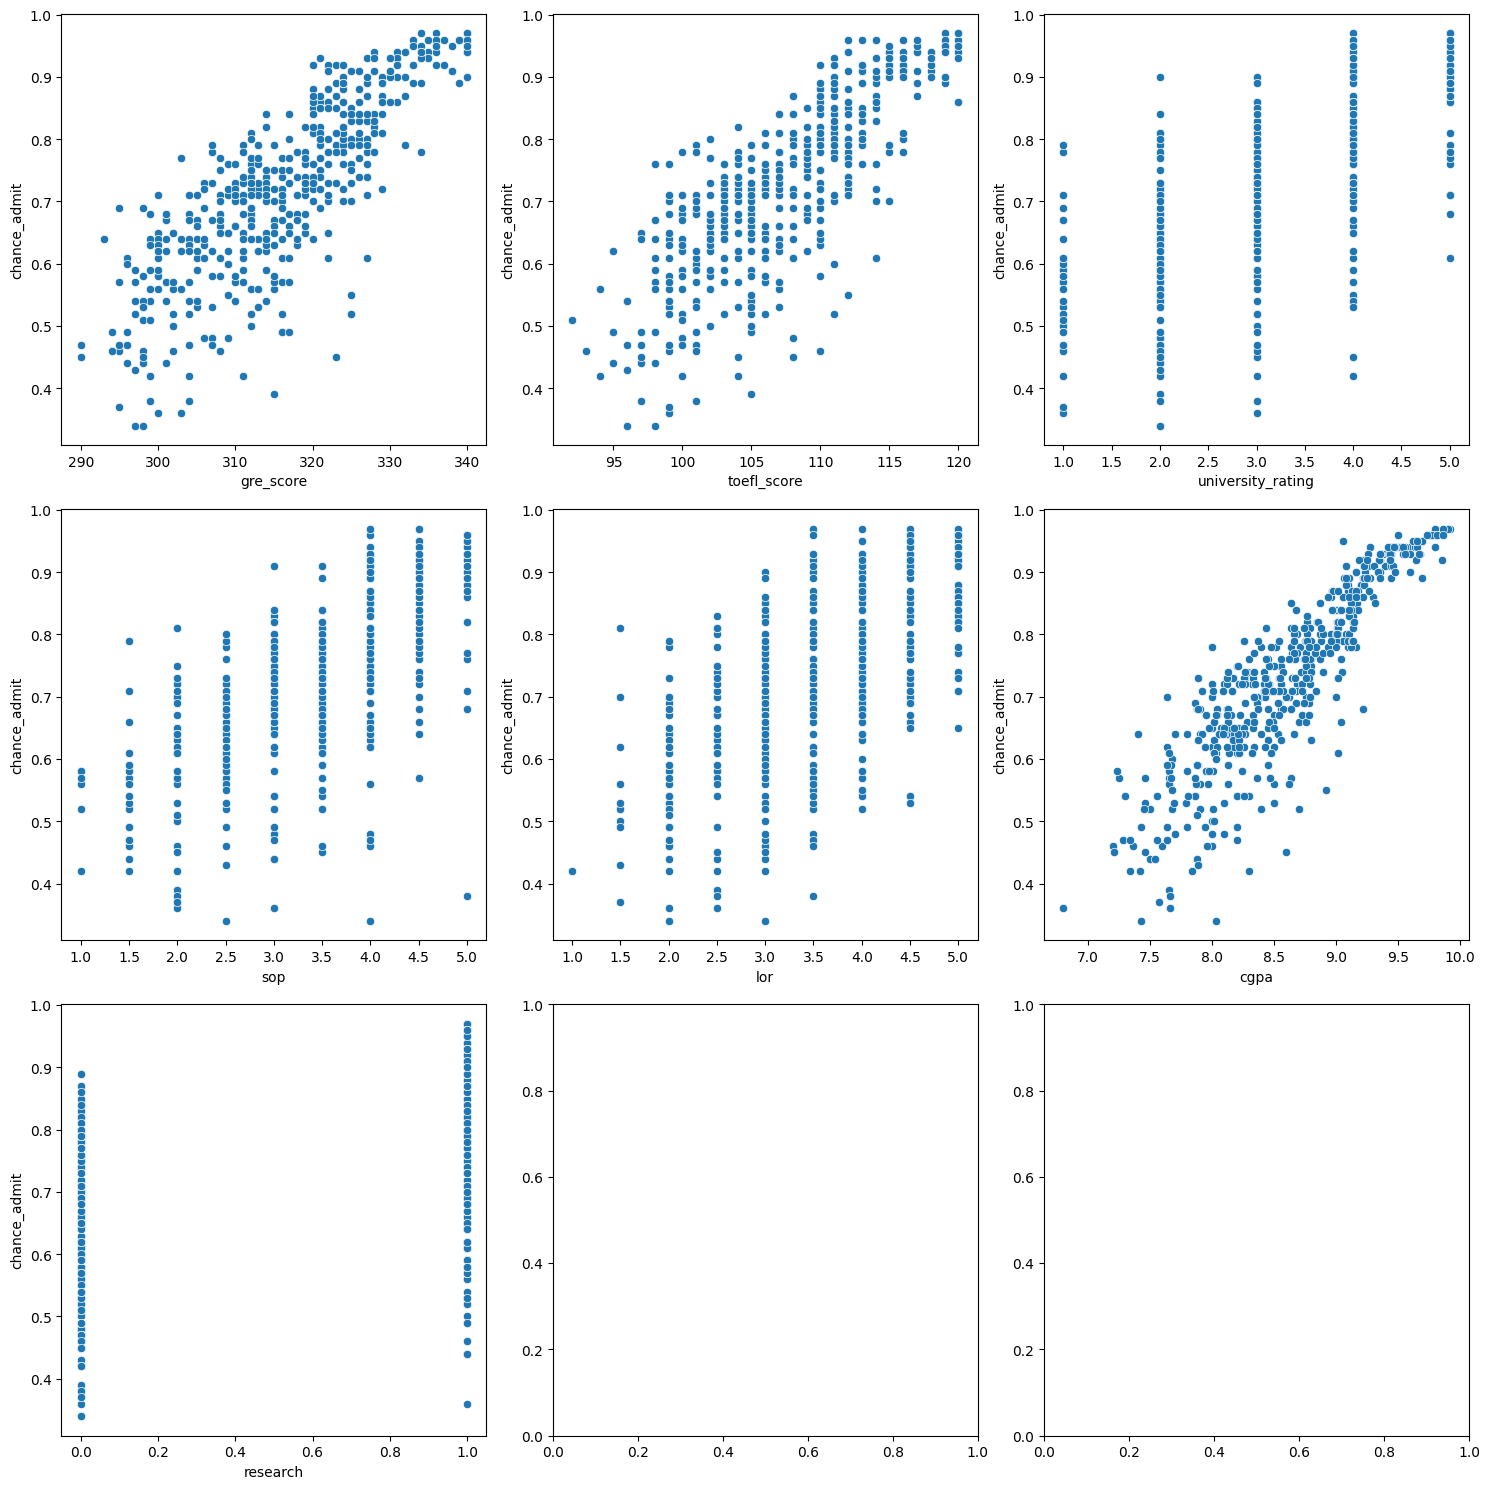

In [ ]:

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

for i, col in enumerate(list(df.columns[:-1])):
    sns.scatterplot(x=col, y='chance_admit', data=df, ax=axes[i])
    # axes[i].set_title(f'Scatter plot of {col} vs Chance of Admit')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

* Linearity condition is met, we see almost straight lines between all X and y variables

# Preparing DataFrame for Modelling

## Train Test Splitting

In [ ]:
df.columns

Index(['gre_score', 'toefl_score', 'university_rating', 'sop', 'lor', 'cgpa',
       'research', 'chance_admit'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['chance_admit'], axis=1)
y = df['chance_admit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 7) (100, 7) (400,) (100,)


## Standard Scaling Variables | Normalization

In [ ]:
scaler = StandardScaler()

x_cols = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=x_cols)
X_test = pd.DataFrame(X_test, columns=x_cols)

### Functions

In [ ]:
def get_vif(df):

  vif = pd.DataFrame()

  vif['features'] = df.columns
  vif['vif'] = [ variance_inflation_factor(df.values, i) for i in range( df.shape[1])]
  vif = vif.sort_values(by='vif', ascending=False)

  return vif


def fit_sm_ols(X_train, y_train):
  X_train_const = sm.add_constant(X_train)
  model = sm.OLS(y_train, X_train_const).fit()
  return model


def get_adj_r2(X, y, r2_score):
  return 1 - (  ((1-r2_score) * (len(y) - 1)) /   (len(y) - X.shape[1] -1 )   )



In [ ]:
# 1.vif  2.signs (optional)  3.p_values


## Reviewing Must Include Variables

<Axes: >

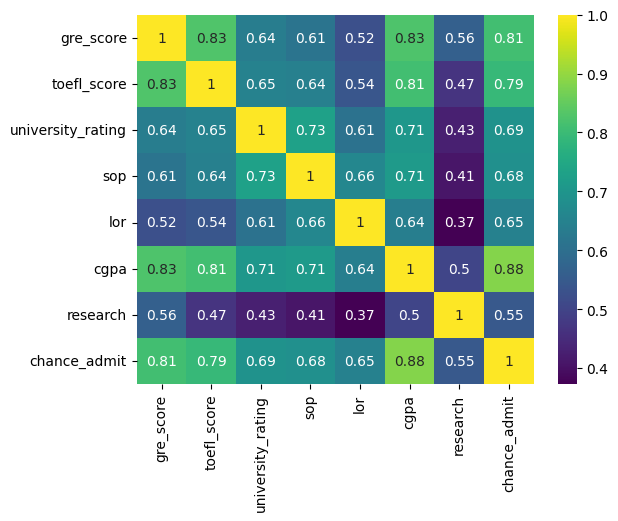

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='viridis')

* cgpa is highly positively correlated with chance_admit, followed by gre_score and toefl_score (all are 80% or above approx), they seem to be primary variables for prediction.
* All X variables are positively correlated with chance_admit.  

In [ ]:
df.columns

Index(['gre_score', 'toefl_score', 'university_rating', 'sop', 'lor', 'cgpa',
       'research', 'chance_admit'],
      dtype='object')

In [ ]:
must_include = ['cgpa', 'gre_score', 'toefl_score', 'university_rating','research']     # , 'sop', 'lor'
get_vif(X_train)

,features,vif
5,cgpa,4.654540
0,gre_score,4.489983
1,toefl_score,3.664298
3,sop,2.785764
2,university_rating,2.572110
4,lor,1.977698
6,research,1.518065


* 'cgpa', 'gre_score', 'toefl_score', 'university_rating','research' all represent performance of a student.
* Set of these variables have < 5 multicollinearity, so there is no need to explicitly define must include variables for this case

## Initial Linear Regression Model

In [ ]:
get_vif(X_train)

,features,vif
5,cgpa,4.654540
0,gre_score,4.489983
1,toefl_score,3.664298
3,sop,2.785764
2,university_rating,2.572110
4,lor,1.977698
6,research,1.518065


* All 7 variables have VIF < 5, so we can have an initial model with all X variables

In [ ]:
# resetting indices for training
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

X_train1 = X_train.drop(columns=['university_rating', 'sop'], axis=1)

ols = fit_sm_ols(X_train, y_train)
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           chance_admit   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     257.0
Date:                Tue, 18 Feb 2025   Prob (F-statistic):          3.41e-142
Time:                        05:53:54   Log-Likelihood:                 561.91
No. Observations:                 400   AIC:                            -1108.
Df Residuals:                     392   BIC:                            -1076.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7242      0.003    241.441      0.000       0.718       0.730
gre_score             0.0267      0.006      4.196      0.000       0.014       0.039
toefl_score           0.0182      0.006      3.174      0.002       0.007       0.030
university_rating     0.0029      0.005      0.611      0.541      -0.007       0.012
sop                   0.0018      0.005      0.357      0.721      -0.008       0.012
lor                   0.0159      0.004      3.761      0.000       0.008       0.024
cgpa                  0.0676      0.006     10.444      0.000       0.055       0.080
research              0.0119      0.004      3.231      0.001       0.005       0.019
==============================================================================
Omnibus:                       86.232   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.099
Skew:                          -1.107   Prob(JB):                     5.25e-42
Kurtosis:                       5.551   Cond. No.                         5.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Overall Linear Regression Model is giving R2 adj of 81.8%, with all 7 variables
* sop and university_rating have high p_values, so these variables are not significant for our model. Their coefficients are also suggesting same.
* We will run Backward Selection of variables in next step to eliminate  

# Backward Selection with Linear Regression

In [ ]:
X_train_ref = X_train.copy()        # to be used to for later sklearn models, Ridge, Lasso ElasticNet

In [ ]:
# iteratively removing variables with 1. High p value + High VIF (1st priority)   2. High VIF (2nd priority)   3. High p Value (3rd priority)

# itr = 0   # for testing only


while True:

  # for testing only
  # itr += 1
  # if itr > 10:
  #   break

  # get vifs > 5
  vif_df = get_vif(X_train)
  vif_df = vif_df[vif_df['vif'] > vif_threshold]
  high_vif_vars = list(vif_df['features'].unique())
  # high_vif_vars = [ c for c in high_vif_vars if c not in must_include]          # must_include not reqd as most key vars are already selecting
  print(vif_df)

  # getting high p_value vars
  high_pvals = ols.pvalues.sort_values(ascending=False)
  high_pvals = high_pvals.drop('const')
  high_pvals = high_pvals[high_pvals > pval_threshold]
  high_pval_vars = list(high_pvals.index)
  # high_pval_vars = [ c for c in high_pval_vars if c not in must_include ]       # must_include not reqd as most key vars are already selecting

  # if no high vifs left ---> break
  if high_vif_vars == [] and high_pval_vars == []:
    break


  # getting common vars
  common_vars = list(set(high_pval_vars) & set(high_vif_vars))
  print(f'----common_vars--------{common_vars}')
  print(f'----high vifs--------{high_vif_vars}')
  print(f'----high p vals--------{high_pval_vars}')

  # Update X vars (train + test)
  if common_vars:
    X_train = X_train.drop(columns=common_vars[0], axis=1)
    X_test = X_test.drop(columns=common_vars[0], axis=1)
  elif high_vif_vars:
    X_train = X_train.drop(columns=high_vif_vars[0], axis=1)
    X_test = X_test.drop(columns=high_vif_vars[0], axis=1)
  else:
    X_train = X_train.drop(columns=high_pval_vars[0], axis=1)
    X_test = X_test.drop(columns=high_pval_vars[0], axis=1)


  # fit model to check performance changes
  ols = fit_sm_ols(X_train, y_train)        # const is added within function
  print('---------------------------')
  print('---------------------------')
  print(ols.summary())


Empty DataFrame
Columns: [features, vif]
Index: []
----common_vars--------[]
----high vifs--------[]
----high p vals--------['sop', 'university_rating']
---------------------------
---------------------------
                            OLS Regression Results                            
Dep. Variable:           chance_admit   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     300.4
Date:                Tue, 18 Feb 2025   Prob (F-statistic):          2.01e-143
Time:                        05:53:54   Log-Likelihood:                 561.85
No. Observations:                 400   AIC:                            -1110.
Df Residuals:                     393   BIC:                            -1082.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
 

In [ ]:
# revalidating vifs all vars
get_vif(X_train)

,features,vif
0,gre_score,4.471557
3,cgpa,4.281365
1,toefl_score,3.540082
2,lor,1.655867
4,research,1.504670


## Normality & Mean of Errors

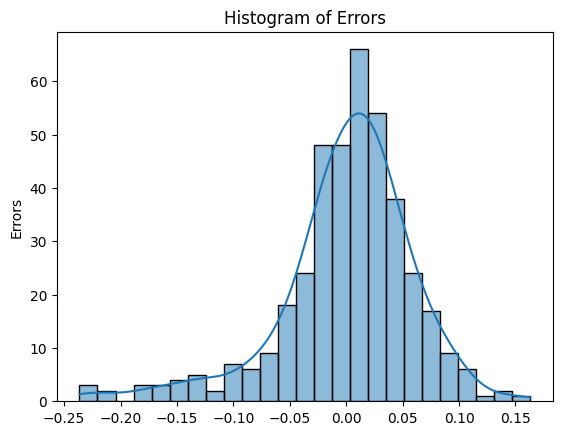

In [ ]:
def check_ols_normality(X_train, y_train):
  X_train_const = sm.add_constant(X_train)

  y_pred = ols.predict(X_train_const)
  errors = y_train-y_pred

  sns.histplot(errors, kde=True)
  plt.title('Histogram of Errors')
  plt.ylabel('Errors')
  plt.show()

  return y_pred, errors

y_pred, errors = check_ols_normality(X_train, y_train)

In [ ]:
result = shapiro(errors)
print(result, f"\nSkewness: {errors.skew()}", f"\nKurtosis: {errors.kurt()}")
print(f"Mean Error: {errors.mean()}")

ShapiroResult(statistic=0.9312566782302102, pvalue=1.3099647192165179e-12) 
Skewness: -1.098089940306712 
Kurtosis: 2.560558510059634
Mean Error: -4.2063574845485617e-16


* Plot suggests that errors are following a Bell Shaped pattern
* Mean of Errors is near to 0
* Errors are left skewed, and peaked (lighter tails)
* Shappiro Test is suggesting a non-Normal distribution, but this is due to some outliers on the left side, which are in acceptable range.
* Overall the Errors are approximating to Normal Distribution with Mean near to 0


## Heteroscedasticity

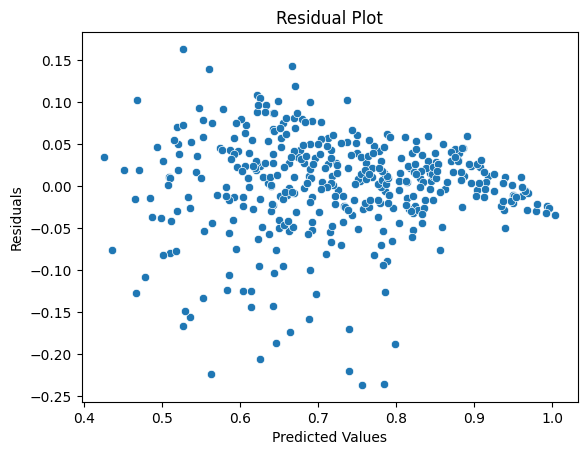

In [ ]:
def plot_residuals(y_pred, errors):
  sns.scatterplot(x=y_pred, y=errors)
  plt.title('Residual Plot')
  plt.xlabel('Predicted Values')
  plt.ylabel('Residuals')
  plt.show()

plot_residuals(y_pred, errors)

In [ ]:
def goldfeld_test(X_train):

  X_train_const = sm.add_constant(X_train)

  name = ['F-statistic', 'p-value']
  test = sms.het_goldfeldquandt(y_train, X_train_const)

  return lzip(name, test)

goldfeld_test(X_train)

[('F-statistic', 0.9592288620962849), ('p-value', 0.6139024845884469)]

* Using GoldFeld test, p-value of 0.61 suggests that errors are almost const across all values of y_pred, so Heteroscedasticity is not present in OLS-LinearRegression model.
* The plot of errors is also suggesting that errors are almost constant across values of y

## Evaluating Model Fitting

In [ ]:
# y_test
# test_error = y_test - ols.predict(sm.add_constant(X_test))

# Training Set Metrics
r2 = r2_score(y_train, ols.predict(sm.add_constant(X_train)))
adj_r2 = get_adj_r2(X_train, y_train, r2)
# print(r2, adj_r2)
print(f"Adj R2 of train set is {adj_r2}")
print(f"RMSE on Train set is: {mean_squared_error(y_train, ols.predict(sm.add_constant(X_train)))}")
print(f"MAPE on train set is {np.mean(np.abs( (y_train - ols.predict(sm.add_constant(X_train) ) ) / y_train) ) * 100}%")

print('\n')

# Test Set Metrics
r2 = r2_score(y_test, ols.predict(sm.add_constant(X_test)))
adj_r2 = get_adj_r2(X_test, y_test, r2)
# print(r2, adj_r2)
print(f"Adj R2 of test set is {adj_r2}")
print(f"RMSE on Test Set is {mean_squared_error(y_test, ols.predict(sm.add_constant(X_test)))}")
print(f"MAPE on test set is {np.mean(np.abs( (y_test - ols.predict(sm.add_constant(X_test))) / y_test)) * 100}%")

Adj R2 of train set is 0.8184577289487925
RMSE on Train set is: 0.0035331469389868714
MAPE on train set is 6.855579749353616%


Adj R2 of test set is 0.8056863883126606
RMSE on Test Set is 0.003773020765116895
MAPE on test set is 6.8724356583899695%


# Backward Selection with sklearn Models

## Functions

In [ ]:
def get_model(model_type, alpha, l1_ratio=l1_ratio):
    if model_type == 'Ridge':
        model = Ridge(alpha=alpha)
    elif model_type == 'Lasso':
        model = Lasso(alpha=alpha)
    elif model_type == 'ElasticNet':
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    else:
        raise ValueError("Invalid model type. Choose from 'Ridge', 'Lasso', or 'ElasticNet'.")

    return model


def fit_sk_model(X_train, y_train, model_type, alpha, l1_ratio):

    model = get_model(model_type, alpha, l1_ratio=l1_ratio)
    model.fit(X_train, y_train)
    return model



In [ ]:
# iteratively removing variables with 1. High VIF
# itr = 0   # for testing only


def backward_selection(X_train, y_train, vif_threshold=vif_threshold, model_type='Ridge', alpha=alpha, l1_ratio=l1_ratio):

  model_flag = False

  while True:

    # for testing only
    # itr += 1
    # if itr > 10:
    #   break

    # get vifs > 5
    vif_df = get_vif(X_train)
    vif_df = vif_df[vif_df['vif'] > vif_threshold]
    high_vif_vars = list(vif_df['features'].unique())
    # high_vif_vars = [ c for c in high_vif_vars if c not in must_include]          # must_include not reqd as most key vars are already selecting
    print(vif_df)


    # if no high vifs left ---> break
    if high_vif_vars == [] :
      if model_flag == False:
        model = fit_sk_model( X_train, y_train, model_type, alpha, l1_ratio=l1_ratio)
      return model, X_train

      break

    print(f'----high vifs--------{high_vif_vars}')

    # Update X vars (train + test)
    if high_vif_vars:
      X_train = X_train.drop(columns=high_vif_vars[0], axis=1)
      X_test = X_test.drop(columns=high_vif_vars[0], axis=1)

      model_flag = True

      # fit model to check performance changes
      model = fit_sk_model(X_train, y_train, model_type, alpha, l1_ratio=l1_ratio)        # const is added within function
      print('---------------------------')
      print('---------------------------')
      # print(ols.summary())


## Ridge

In [ ]:
from sklearn.metrics import mean_squared_error


ridge, X_train1 = backward_selection(X_train_ref, y_train, vif_threshold=vif_threshold, model_type='Ridge', alpha=alpha)
y_pred = ridge.predict(X_train1)
print(f'R2 Score : {r2_score(y_pred, y_train)}')
print(f'Adj R2 Score : {get_adj_r2(X_train1, y_train, r2_score(y_pred, y_train))}')
print(f'Mean Squared Error : {mean_squared_error(y_pred, y_train)}')

Empty DataFrame
Columns: [features, vif]
Index: []
R2 Score : 0.7820322596286277
Adj R2 Score : 0.7781399785505674
Mean Squared Error : 0.003526556283339688


In [ ]:
X_train2, X_val,  y_train2, y_val = train_test_split(X_train1, y_train, test_size=0.2, random_state=42)

all_alpha = [0.00001 * (10 ** i) for i in range(7)]
all_alpha += [50, 100, 200, 500, 700, 1000]


for a in all_alpha:
      ridge = fit_sk_model( X_train2, y_train2, 'Ridge', alpha=a, l1_ratio=l1_ratio)
      y_pred = ridge.predict(X_train2)

      print( a, f'Adj R2 Score : {get_adj_r2(X_train2, y_train2, r2_score(y_pred, y_train2))}')
      print( a, f'Mean Squared Error : {mean_squared_error(y_pred, y_train2)}')


1e-05 Adj R2 Score : 0.7740742456671815
1e-05 Mean Squared Error : 0.0037367390322690873
0.0001 Adj R2 Score : 0.7740742023433888
0.0001 Mean Squared Error : 0.00373673903227027
0.001 Adj R2 Score : 0.7740737691023771
0.001 Mean Squared Error : 0.0037367390323885586
0.01 Adj R2 Score : 0.774069436384026
0.01 Mean Squared Error : 0.003736739044213913
0.1 Adj R2 Score : 0.7740260784967263
0.1 Mean Squared Error : 0.0037367402232375765
1.0 Adj R2 Score : 0.7735895455207402
1.0 Mean Squared Error : 0.0037368547090133723
10.0 Adj R2 Score : 0.7690174364632629
10.0 Mean Squared Error : 0.003745640370589866
50 Adj R2 Score : 0.7476201550410027
50 Mean Squared Error : 0.003839001667733219
100 Adj R2 Score : 0.7206267126324437
100 Mean Squared Error : 0.003969747678365019
200 Adj R2 Score : 0.6629594510073669
200 Mean Squared Error : 0.004234919661857691
500 Adj R2 Score : 0.4362375957339466
500 Mean Squared Error : 0.005137619731423437
700 Adj R2 Score : 0.23356391893200212
700 Mean Squared Er

## Lasso

In [ ]:
lasso, X_train1 = backward_selection(X_train_ref, y_train, vif_threshold=vif_threshold, model_type='Lasso', alpha=alpha)
y_pred = lasso.predict(X_train1)
print(f'R2 Score : {r2_score(y_pred, y_train)}')
print(f'Mean Squared Error : {mean_squared_error(y_pred, y_train)}')

Empty DataFrame
Columns: [features, vif]
Index: []
R2 Score : -25.78693407737931
Mean Squared Error : 0.014511941024689905


In [ ]:
# X_train2, X_val,  y_train2, y_val = train_test_split(X_train1, y_train, test_size=0.2, random_state=42)

all_alpha = [0.00001 * (10 ** i) for i in range(7)]
all_alpha += [50, 100, 200, 500, 700, 1000]


for a in all_alpha:
      ridge = fit_sk_model( X_train2, y_train2, 'Lasso', alpha=a, l1_ratio=l1_ratio)
      y_pred = ridge.predict(X_train2)

      print( a, f'Adj R2 Score : {get_adj_r2(X_train2, y_train2, r2_score(y_pred, y_train2))}')
      print( a, f'Mean Squared Error : {mean_squared_error(y_pred, y_train2)}')


1e-05 Adj R2 Score : 0.7740342905754989
0.0001 Adj R2 Score : 0.7736696003834076
0.001 Adj R2 Score : 0.7699697737315414
0.01 Adj R2 Score : 0.7176709004124979
0.1 Adj R2 Score : -20.39973506123193
1.0 Adj R2 Score : -1.7127070431091017e+30
10.0 Adj R2 Score : -1.7127070431091017e+30
50 Adj R2 Score : -1.7127070431091017e+30
100 Adj R2 Score : -1.7127070431091017e+30
200 Adj R2 Score : -1.7127070431091017e+30
500 Adj R2 Score : -1.7127070431091017e+30
700 Adj R2 Score : -1.7127070431091017e+30
1000 Adj R2 Score : -1.7127070431091017e+30


# ElasticNet

In [ ]:
elasticnet, X_train1 = backward_selection(X_train_ref, y_train, vif_threshold=vif_threshold, model_type='ElasticNet', alpha=alpha, l1_ratio=l1_ratio)
y_pred = elasticnet.predict(X_train1)
print(f'R2 Score : {r2_score(y_pred, y_train)}')
print(f'Mean Squared Error : {mean_squared_error(y_pred, y_train)}')

Empty DataFrame
Columns: [features, vif]
Index: []
R2 Score : -0.3386816807263391
Mean Squared Error : 0.0068393780067496


In [ ]:
# X_train2, X_val,  y_train2, y_val = train_test_split(X_train1, y_train, test_size=0.2, random_state=42)

all_alpha = [0.00001 * (10 ** i) for i in range(7)]
all_alpha += [50, 100, 200, 500, 700, 1000]


for a in all_alpha:
      ridge = fit_sk_model( X_train2, y_train2, 'ElasticNet', alpha=a, l1_ratio=l1_ratio)
      y_pred = ridge.predict(X_train2)

      print( a, f'Adj R2 Score : {get_adj_r2(X_train2, y_train2, r2_score(y_pred, y_train2))}')
      print( a, f'Mean Squared Error : {mean_squared_error(y_pred, y_train2)}')



1e-05 Adj R2 Score : 0.7740535192504759
0.0001 Adj R2 Score : 0.7738641396186379
0.001 Adj R2 Score : 0.7719758783194217
0.01 Adj R2 Score : 0.7494616079255482
0.1 Adj R2 Score : -0.2910072098734655
1.0 Adj R2 Score : -1.7127070431091017e+30
10.0 Adj R2 Score : -1.7127070431091017e+30
50 Adj R2 Score : -1.7127070431091017e+30
100 Adj R2 Score : -1.7127070431091017e+30
200 Adj R2 Score : -1.7127070431091017e+30
500 Adj R2 Score : -1.7127070431091017e+30
700 Adj R2 Score : -1.7127070431091017e+30
1000 Adj R2 Score : -1.7127070431091017e+30


In [ ]:

all_l1 = [0.00001 * (10 ** i) for i in range(6)]

for l1 in all_l1:
      ridge = fit_sk_model( X_train2, y_train2, 'ElasticNet', alpha=1e-05, l1_ratio=l1)
      y_pred = ridge.predict(X_train2)

      print( l1, f'Adj R2 Score : {get_adj_r2(X_train2, y_train2, r2_score(y_pred, y_train2))}')
      print( l1, f'Mean Squared Error : {mean_squared_error(y_pred, y_train2)}')


1e-05 Adj R2 Score : 0.7740727096594135
1e-05 Mean Squared Error : 0.003736739033492709
0.0001 Adj R2 Score : 0.7740727062783137
0.0001 Mean Squared Error : 0.0037367390334947306
0.001 Adj R2 Score : 0.7740726728890448
0.001 Mean Squared Error : 0.0037367390335165582
0.01 Adj R2 Score : 0.7740723380125124
0.01 Mean Squared Error : 0.003736739033829692
0.1 Adj R2 Score : 0.7740689233865973
0.1 Mean Squared Error : 0.003736739046969901
1.0 Adj R2 Score : 0.7740342905754989
1.0 Mean Squared Error : 0.0037367401688909105


# Run Anchor